In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
from datetime import datetime

### Fruit Data Multiclass using KNN, LogisticRegression (L1, L2) and LogisticSVM(L1, L2)

Load fruit_data_with_colors.txt Data Set into a dataframe and displaying its first 5 entries.


In [2]:
df_fruits = pd.read_table('fruit_data_with_colors.txt')
df_fruits.head(5)

,fruit_label,fruit_name,fruit_subtype,mass,width,height,color_score
0,1,apple,granny_smith,192,8.4,7.3,0.55
1,1,apple,granny_smith,180,8.0,6.8,0.59
2,1,apple,granny_smith,176,7.4,7.2,0.60
3,2,mandarin,mandarin,86,6.2,4.7,0.80
4,2,mandarin,mandarin,84,6.0,4.6,0.79


Checking null values if needs any imputation.

In [3]:
df_fruits.isnull().sum()

fruit_label      0
fruit_name       0
fruit_subtype    0
mass             0
width            0
height           0
color_score      0
dtype: int64

Checking stats of each column in the Data Frame using describe to see the data distribution and how far the data are from each other.

In [4]:
df_fruits.describe()

,fruit_label,mass,width,height,color_score
count,59.000000,59.000000,59.000000,59.000000,59.000000
mean,2.542373,163.118644,7.105085,7.693220,0.762881
std,1.208048,55.018832,0.816938,1.361017,0.076857
min,1.000000,76.000000,5.800000,4.000000,0.550000
25%,1.000000,140.000000,6.600000,7.200000,0.720000
50%,3.000000,158.000000,7.200000,7.600000,0.750000
75%,4.000000,177.000000,7.500000,8.200000,0.810000
max,4.000000,362.000000,9.600000,10.500000,0.930000


### Distribution plot of each Fruit kind and its features.
Apple, Orange and Lemon have good amount of distribution with this data set. However mandarin only has 4 data points and ideally a 75-25 Train-Test split may suffice.

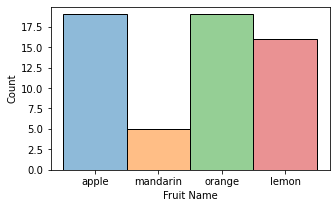

In [5]:
plt.rcParams["figure.figsize"] = (5, 3)
ax = sns.histplot(df_fruits, x="fruit_name", hue="fruit_name")
ax.legend([],[], frameon=False)
ax.set_xlabel('Fruit Name')
plt.show()

We've also considered using the subtype as the Target but it would further increase the complexity in the classes given how small our data set is already and its features are very close to each other.

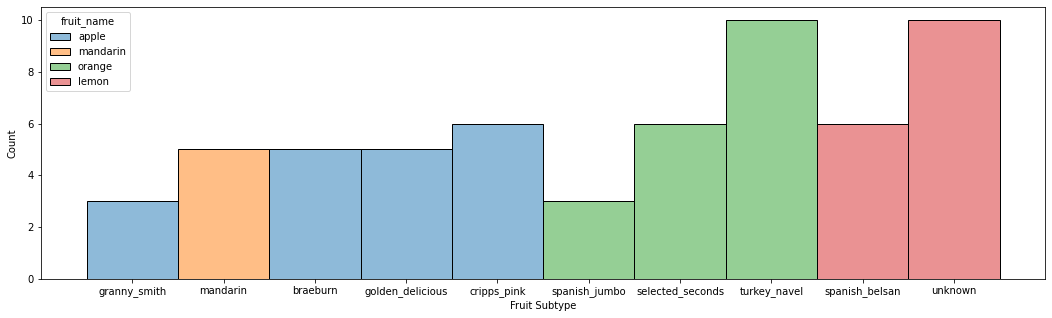

In [6]:
plt.rcParams["figure.figsize"] = (18, 5)
ax = sns.histplot(df_fruits, x="fruit_subtype", hue="fruit_name")
ax.set_xlabel('Fruit Subtype')
plt.show()

### Distribution Histogram for each Feature
We wanted to look into the distribution of each feature to better understand how we can differentiate each fruit.
What we've noticed Mandarin's features for mass, width and height are easily distinguishable. Apple and Orange have almost same distribution for its features except color_score. Then lemon is both skewed in one side for its height and width.

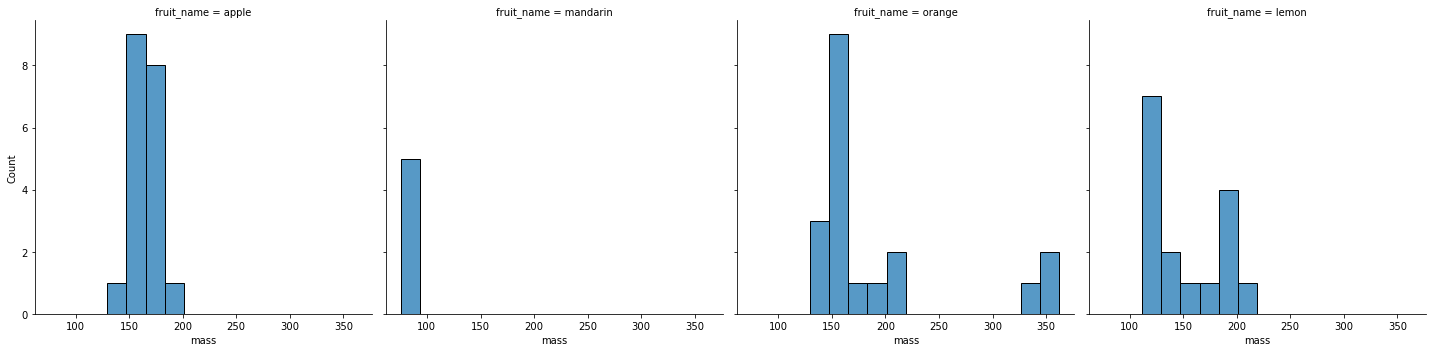

In [7]:
plt.rcParams["figure.figsize"] = (3, 2)
ax = sns.displot(df_fruits, x="mass", col="fruit_name", kind='hist')
plt.show()

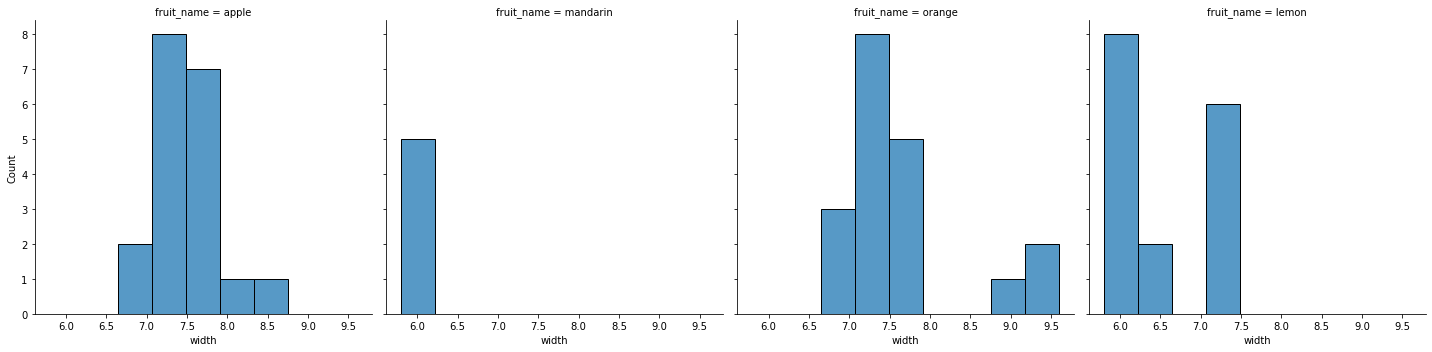

In [8]:
plt.rcParams["figure.figsize"] = (3, 2)
ax = sns.displot(df_fruits, x="width", col="fruit_name", kind='hist')
plt.show()

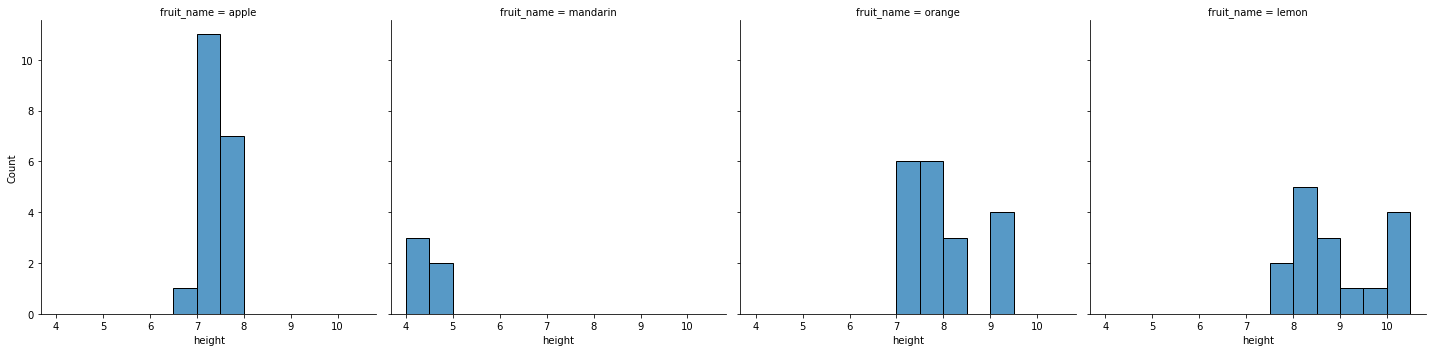

In [9]:
plt.rcParams["figure.figsize"] = (3, 2)
ax = sns.displot(df_fruits, x="height", col="fruit_name", kind='hist')
plt.show()

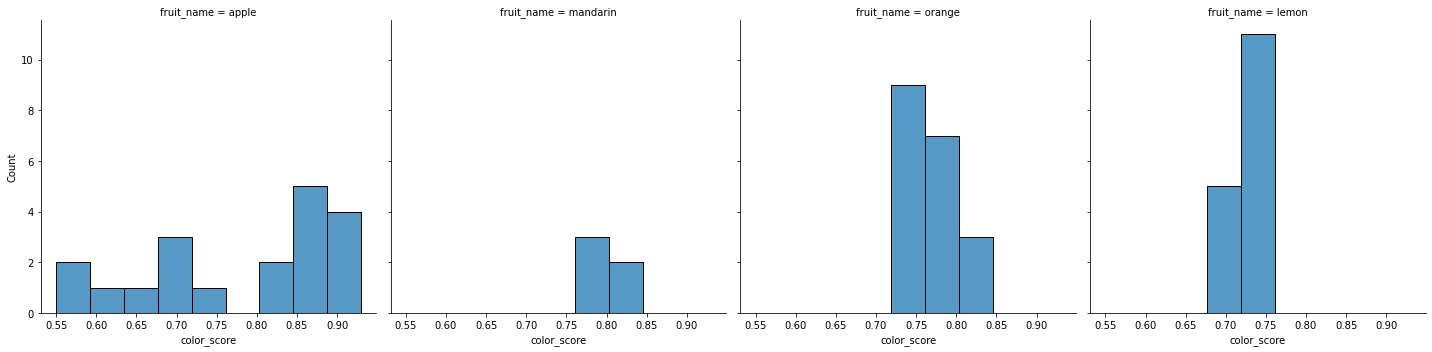

In [10]:
plt.rcParams["figure.figsize"] = (3, 2)
ax = sns.displot(df_fruits, x="color_score", col="fruit_name", kind='hist')
plt.show()

### Scatter Pairplots to visualize the relationship of each feature and if there's a pattern.
As seen in the distribution feature charts the mandarin can be easily spotted in its own region for each of its feature combination in the matrix.
Lemon can be easily be grouped with its height and width, while apple and oranges are overlapping each other in a certain section where we can make use of mass or color_score to help distinguished them from each other and we've tried using a derived features (width, height, color_score) and (width, height, mass) to see if it improves which will show at the execution part of this notebook.


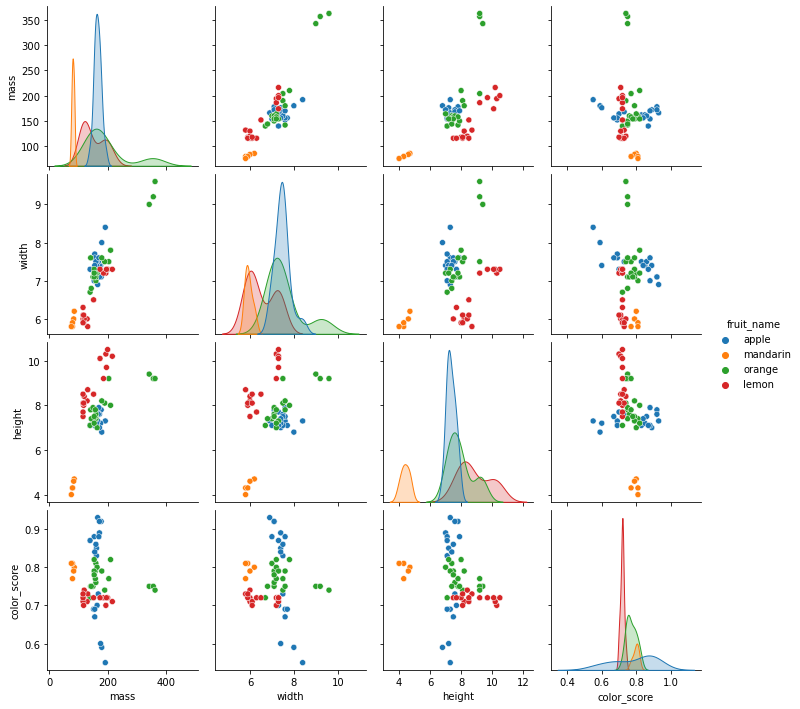

In [11]:
df_scatter = df_fruits.drop('fruit_label', axis=1)
sns.pairplot(df_scatter, hue="fruit_name")

### Models used for prediction and how we updated our code
We did a base run separate notebook using the original parameters for both L1, L2 LogisticRegression and L1 and L2 SVM and initially, it did not run so we changed the parameters for each here are the findings. <br> <br>
L1 LR with liblinear does not converge even with 10m iterations so we needed to modify the solver. <br> <br>
L2 LR was encountering errors with the default ‘lbfgs’ solver and we tried all solvers available, and ‘saga’ was having the best result, however, in the documentation, this is ideal for large datasets, and we don’t have large one in our case, so this is something we wanted to do further research. <br> <br>
For both SVM L1 L2 we increased the iterations to 10m since when adding the derived features we have it fails to converge. <br>
We also played around with the multi_class option and we saw that multinomial is performing better over OVR for LR hence we just left it to auto and crammer_singer does not converge for SVM so we kept it back to OVR. <br> <br>
KNN worked as expected and we just used the train samples – 1 as our data K for the tests. <br> <br>
We have also modified the code for top predictor where we returned the top predictor for each class and took the mean of the features across to identify the overall top predictor <br> <br>
We have set our trials = at 30 <br>
C from 1e8 to 1e-8 to 5000 <br>
Train-Test split 75-25 <br>




In [12]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split

Number_trials = 30
t_size = 0.25
C = [1e-8, 1e-4, 1e-3, 1e-2, 0.1, 0.2,0.4, 0.75, 1, 
     1.5, 3, 5, 10, 15, 20, 100, 300, 1000, 5000]

def train_knn(X, y):
    
    start_time = time.time()
    score_train = []
    score_test = []
    print(f'KNN Start: {datetime.now()}')

    for seed in range(Number_trials):
        X_train, X_test, y_train, y_test = (train_test_split(X, y, 
                                                             test_size=t_size, 
                                                             random_state=seed))
        n_knn = len(X_train) - 1
        neighbors_settings = range(1, n_knn)
        acc_train = []
        acc_test = []

        for n_neighbors in neighbors_settings:
            clf = KNeighborsClassifier(n_neighbors=n_neighbors, weights='distance') 
            clf.fit(X_train, y_train)    
            acc_train.append(clf.score(X_train, y_train))
            acc_test.append(clf.score(X_test, y_test))

        score_train.append(acc_train)
        score_test.append(acc_test)   
        
    score = np.mean(score_test, axis=0)
    run_time = (time.time() - start_time)
    return ['kNN', np.amax(score), 'N_Neighbor = {0}'
            .format(np.argmax(score)+1), 'NA', 'NA', run_time]

def train_logistic(X, y, reg):
    
    start_time = time.time()
    score_train = []
    score_test = []
    weighted_coefs=[]
    
    print(f'Logistics {reg} Start: {datetime.now()}')
    
    for seed in range(Number_trials):
        training_accuracy = []  
        test_accuracy = []
        X_train, X_test, y_train, y_test = (train_test_split(X, y, test_size=
                                                             t_size, 
                                                             random_state=seed
                                                             ))
        for alpha_run in C:
            if reg == 'l1':
                lr = (LogisticRegression(C=alpha_run, penalty=reg, 
                                         solver='saga', max_iter=1000000).fit(X_train, y_train))
            if reg == 'l2':
                lr = (LogisticRegression(C=alpha_run, penalty=reg, solver='saga',
                                         dual=False, max_iter=1000000).fit(X_train, y_train))

            training_accuracy.append(lr.score(X_train, y_train))
            test_accuracy.append(lr.score(X_test, y_test))
            coefs=lr.coef_ 
            weighted_coefs.append(coefs) 
                
        score_train.append(training_accuracy)
        score_test.append(test_accuracy)
    
    mean_coefs = np.mean(np.mean(weighted_coefs, axis=0), axis=1)
    score = np.mean(score_test, axis=0)
    top_pred_var = ([f'{lr.classes_[i]}: {X.columns[np.argmax(weights)]}' 
                     for i, weights in enumerate(np.abs(np.mean(weighted_coefs, axis=0)))])

    #Plot the weight of the parameters
    top_predictor=X.columns[np.argmax(np.abs(mean_coefs))]
    abs_mean_coefs = np.abs(mean_coefs)
    coefs_count = len(abs_mean_coefs)
    fig, ax = plt.subplots(figsize=(2,5))
    ax.barh(np.arange(coefs_count), sorted(abs_mean_coefs))
     
    ax.set_yticks(np.arange(coefs_count))
    ax.set_yticklabels(X.columns[np.argsort(abs_mean_coefs)])
    
    run_time = (time.time() - start_time)
    return ['Logistic ({0})'.format(reg), np.amax(score), \
            'C = {0}'.format(C[np.argmax(score)]), top_predictor, 
            top_pred_var , run_time]

def train_svm(X, y, reg):
    
    #C = [.01, .1]
    start_time = time.time()
    score_train = []
    score_test = []
    weighted_coefs=[]
    print(f'SVCM {reg} Start: {datetime.now()}')
    for seed in range(Number_trials):
        training_accuracy = []  
        test_accuracy = []
        X_train, X_test, y_train, y_test = (train_test_split(X, y, test_size=
                                                             t_size, 
                                                             random_state=seed
                                                             ))
        for alpha_run in C:
            if reg == 'l1':
                svc = (LinearSVC(C=alpha_run, penalty=reg,loss='squared_hinge',
                                max_iter=10000000, dual=False).fit(X_train, y_train))
            if reg == 'l2':
                svc = (LinearSVC(C=alpha_run, penalty=reg, max_iter=10000000)
                                .fit(X_train, y_train))
            training_accuracy.append(svc.score(X_train, y_train))
            test_accuracy.append(svc.score(X_test, y_test))
           # if alpha_run == 0.01:
            coefs = svc.coef_
            weighted_coefs.append(coefs)
                
        score_train.append(training_accuracy)
        score_test.append(test_accuracy)
 

    mean_coefs=np.mean(np.mean(weighted_coefs, axis=0), axis=1) 
    score = np.mean(score_test, axis=0)
    top_pred_var = ([f'{svc.classes_[i]}: {X.columns[np.argmax(weights)]}' 
                    for i, weights in enumerate(np.abs(np.mean(weighted_coefs, axis=0)))])

    top_predictor=X.columns[np.argmax(np.abs(mean_coefs))]
    abs_mean_coefs = np.abs(mean_coefs)
    coefs_count = len(abs_mean_coefs)
    fig, ax = plt.subplots(figsize=(2,5))
    ax.barh(np.arange(coefs_count), sorted(abs_mean_coefs))
        
    ax.set_yticks(np.arange(coefs_count))
    ax.set_yticklabels(X.columns[np.argsort(abs_mean_coefs)])
    
    run_time = (time.time() - start_time)
    return ['Linear SVM ({0})'.format(reg), np.amax(score), \
            'C = {0}'.format(C[np.argmax(score)]), top_predictor, 
             top_pred_var, run_time]


In [13]:
def print_output(X, y):

    knn = train_knn(X, y)
    print(knn)
    print("%s seconds" % knn[4])

    l2_log = train_logistic(X, y, reg='l2')
    print(l2_log)
    print("%s seconds" % l2_log[4])

    l1_log = train_logistic(X, y, reg='l1')
    print(l1_log)
    print("%s seconds" % l1_log[4])

    l2_svm = train_svm(X, y, reg='l2')
    print(l2_svm)
    print("%s seconds" % l2_svm[4])


    l1_svm = train_svm(X, y, reg='l1')
    print(l1_svm)
    print("%s seconds" % l1_svm[4])

    cols = ['Machine Learning Method', 'Test Accuracy', 'Best Parameter', 
            'Top Mean Predictor Variable', 'Mean Predictor Per Class', 'Run Time']
    df2 = pd.DataFrame(columns=cols)

    df2.loc[0] = knn
    df2.loc[1] = l2_log
    df2.loc[2] = l1_log
    df2.loc[3] = l2_svm
    df2.loc[4] = l1_svm

    return df2


### Baseline Run

Here we have used MinMaxScaler to normalize the data since there are no heavy outliers.<br>
KNN is the top predictor based on the table below using all 4 features.

KNN Start: 2022-11-02 22:14:33.034577
['kNN', 0.957777777777778, 'N_Neighbor = 4', 'NA', 'NA', 3.4977869987487793]
NA seconds
Logistics l2 Start: 2022-11-02 22:14:36.532364
['Logistic (l2)', 0.8088888888888892, 'C = 1000', 'width', ['1: width', '2: height', '3: mass', '4: height'], 2.4271163940429688]
['1: width', '2: height', '3: mass', '4: height'] seconds
Logistics l1 Start: 2022-11-02 22:14:38.960481
['Logistic (l1)', 0.8111111111111114, 'C = 1000', 'width', ['1: width', '2: height', '3: mass', '4: height'], 4.909104585647583]
['1: width', '2: height', '3: mass', '4: height'] seconds
SVCM l2 Start: 2022-11-02 22:14:43.869586
['Linear SVM (l2)', 0.7066666666666669, 'C = 1000', 'width', ['1: width', '2: height', '3: mass', '4: height'], 21.641880750656128]
['1: width', '2: height', '3: mass', '4: height'] seconds
SVCM l1 Start: 2022-11-02 22:15:05.511466
['Linear SVM (l1)', 0.7111111111111114, 'C = 100', 'width', ['1: width', '2: height', '3: mass', '4: width'], 1.4143180847167969]
[

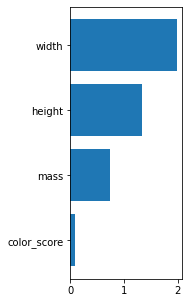

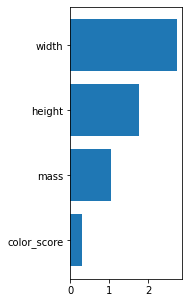

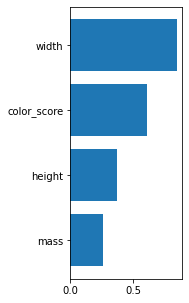

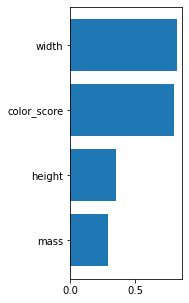

In [14]:
from sklearn.preprocessing import MinMaxScaler
sscaler = MinMaxScaler()
X = df_fruits[['mass', 'width', 'height', 'color_score']]
XX = sscaler.fit_transform(X.astype(float))
X = pd.DataFrame(data = XX,columns = ['mass', 'width', 'height', 'color_score'])
y = df_fruits['fruit_label']

df = print_output(X, y)    

In [15]:
display(df)

,Machine Learning Method,Test Accuracy,Best Parameter,Top Mean Predictor Variable,Mean Predictor Per Class,Run Time
0,kNN,0.957778,N_Neighbor = 4,NA,NA,3.497787
1,Logistic (l2),0.808889,C = 1000,width,"[1: width, 2: height, 3: mass, 4: height]",2.427116
2,Logistic (l1),0.811111,C = 1000,width,"[1: width, 2: height, 3: mass, 4: height]",4.909105
3,Linear SVM (l2),0.706667,C = 1000,width,"[1: width, 2: height, 3: mass, 4: height]",21.641881
4,Linear SVM (l1),0.711111,C = 100,width,"[1: width, 2: height, 3: mass, 4: width]",1.414318


### Added Derived Feature 

We have tried using both the width, height, mass and width, height, color_score and between the two the latter performed better in all tests. To just not make the notebook longer we just retained the better performing feature. We also combined them it did not increase the accuracy further. <br><br>

Here KNN is still the top predictor but reduced the accuracy by .002 however the rest of the linear models have increased with SVM having 4%+ increase.

KNN Start: 2022-11-02 22:15:07.083821
['kNN', 0.9555555555555557, 'N_Neighbor = 4', 'NA', 'NA', 3.4437742233276367]
NA seconds
Logistics l2 Start: 2022-11-02 22:15:10.527595
['Logistic (l2)', 0.8133333333333338, 'C = 5000', 'width', ['1: width', '2: height', '3: mass', '4: height'], 2.947662830352783]
['1: width', '2: height', '3: mass', '4: height'] seconds
Logistics l1 Start: 2022-11-02 22:15:13.475258
['Logistic (l1)', 0.8133333333333338, 'C = 100', 'width', ['1: width', '2: height', '3: mwh', '4: height'], 7.70275616645813]
['1: width', '2: height', '3: mwh', '4: height'] seconds
SVCM l2 Start: 2022-11-02 22:15:21.179014
['Linear SVM (l2)', 0.7466666666666668, 'C = 5000', 'mass', ['1: mwh', '2: height', '3: mwh', '4: height'], 21.748896598815918]
['1: mwh', '2: height', '3: mwh', '4: height'] seconds
SVCM l1 Start: 2022-11-02 22:15:42.927911
['Linear SVM (l1)', 0.7533333333333335, 'C = 100', 'mass', ['1: mwh', '2: height', '3: mwh', '4: width'], 8.815180778503418]
['1: mwh', '2: he

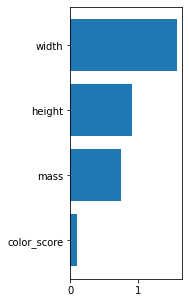

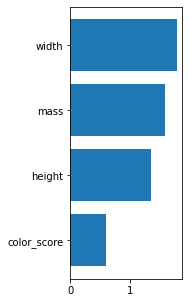

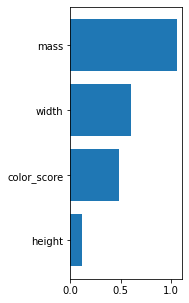

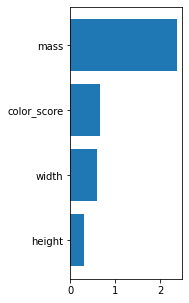

In [16]:
from sklearn.preprocessing import MinMaxScaler
sscaler = MinMaxScaler()
df_fruits_ext = df_fruits.copy()
#df_fruits_ext['mwh'] = df_fruits.width * df_fruits.height * df_fruits.mass
df_fruits_ext['mwh'] = df_fruits.width * df_fruits.height * df_fruits.color_score
X = df_fruits_ext[['mass', 'width', 'height', 'color_score', 'mwh']]
XX = sscaler.fit_transform(X.astype(float))
X = pd.DataFrame(data = XX,columns = ['mass', 'width', 'height', 'color_score', 'mwh'])
y = df_fruits['fruit_label']

df = print_output(X, y)  

In [17]:
display(df)

,Machine Learning Method,Test Accuracy,Best Parameter,Top Mean Predictor Variable,Mean Predictor Per Class,Run Time
0,kNN,0.955556,N_Neighbor = 4,NA,NA,3.443774
1,Logistic (l2),0.813333,C = 5000,width,"[1: width, 2: height, 3: mass, 4: height]",2.947663
2,Logistic (l1),0.813333,C = 100,width,"[1: width, 2: height, 3: mwh, 4: height]",7.702756
3,Linear SVM (l2),0.746667,C = 5000,mass,"[1: mwh, 2: height, 3: mwh, 4: height]",21.748897
4,Linear SVM (l1),0.753333,C = 100,mass,"[1: mwh, 2: height, 3: mwh, 4: width]",8.815181


### Adjusted scale for color_score

We adjusted the scale for color_score and squared it and it pushed KNN accuracy to 98.88% which is so far the best performing model. LR is kept as same percentage and SVM losing a few points.

KNN Start: 2022-11-02 22:15:51.913129
['kNN', 0.9688888888888889, 'N_Neighbor = 1', 'NA', 'NA', 3.5097897052764893]
NA seconds
Logistics l2 Start: 2022-11-02 22:15:55.422919
['Logistic (l2)', 0.8111111111111114, 'C = 5000', 'width', ['1: height', '2: height', '3: mass', '4: height'], 3.4503469467163086]
['1: height', '2: height', '3: mass', '4: height'] seconds
Logistics l1 Start: 2022-11-02 22:15:58.873266
['Logistic (l1)', 0.8111111111111114, 'C = 100', 'height', ['1: height', '2: height', '3: mass', '4: height'], 8.453920602798462]
['1: height', '2: height', '3: mass', '4: height'] seconds
SVCM l2 Start: 2022-11-02 22:16:07.328186
['Linear SVM (l2)', 0.7422222222222223, 'C = 1000', 'mass', ['1: mwh', '2: height', '3: mass', '4: height'], 28.300748586654663]
['1: mwh', '2: height', '3: mass', '4: height'] seconds
SVCM l1 Start: 2022-11-02 22:16:35.628935
['Linear SVM (l1)', 0.7400000000000001, 'C = 100', 'mass', ['1: mwh', '2: height', '3: mass', '4: width'], 4.738434076309204]
['1: 

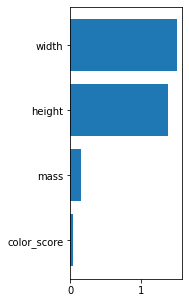

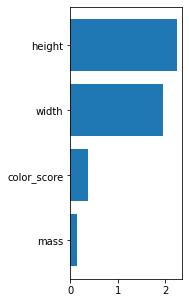

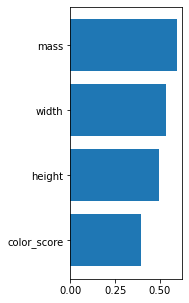

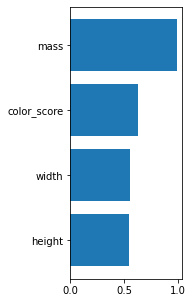

In [18]:
from sklearn.preprocessing import MinMaxScaler
sscaler = MinMaxScaler()
df_fruits_ext = df_fruits.copy()
#df_fruits_ext['mwh'] = df_fruits.width * df_fruits.height * (df_fruits.mass**2)
df_fruits_ext['mwh'] = df_fruits.width * df_fruits.height * (df_fruits.color_score**2)
X = df_fruits_ext[['mass', 'width', 'height', 'color_score', 'mwh']]
XX = sscaler.fit_transform(X.astype(float))
X = pd.DataFrame(data = XX,columns = ['mass', 'width', 'height', 'color_score', 'mwh'])
y = df_fruits['fruit_label']

df = print_output(X, y)  

In [19]:
display(df)

,Machine Learning Method,Test Accuracy,Best Parameter,Top Mean Predictor Variable,Mean Predictor Per Class,Run Time
0,kNN,0.968889,N_Neighbor = 1,NA,NA,3.509790
1,Logistic (l2),0.811111,C = 5000,width,"[1: height, 2: height, 3: mass, 4: height]",3.450347
2,Logistic (l1),0.811111,C = 100,height,"[1: height, 2: height, 3: mass, 4: height]",8.453921
3,Linear SVM (l2),0.742222,C = 1000,mass,"[1: mwh, 2: height, 3: mass, 4: height]",28.300749
4,Linear SVM (l1),0.740000,C = 100,mass,"[1: mwh, 2: height, 3: mass, 4: width]",4.738434


### Combining with mass

Adding mass did not help improving the overall accuracy but reduced it might be because we just combined all 4 columns and returned to its original predictions.

KNN Start: 2022-11-02 22:16:40.617393
['kNN', 0.957777777777778, 'N_Neighbor = 4', 'NA', 'NA', 3.5779500007629395]
NA seconds
Logistics l2 Start: 2022-11-02 22:16:44.195343
['Logistic (l2)', 0.806666666666667, 'C = 300', 'width', ['1: width', '2: height', '3: mwh', '4: height'], 2.823633909225464]
['1: width', '2: height', '3: mwh', '4: height'] seconds
Logistics l1 Start: 2022-11-02 22:16:47.018977
['Logistic (l1)', 0.806666666666667, 'C = 100', 'width', ['1: width', '2: height', '3: mwh', '4: height'], 6.425446510314941]
['1: width', '2: height', '3: mwh', '4: height'] seconds
SVCM l2 Start: 2022-11-02 22:16:53.444424
['Linear SVM (l2)', 0.7288888888888891, 'C = 300', 'width', ['1: mwh', '2: height', '3: mass', '4: height'], 23.462282180786133]
['1: mwh', '2: height', '3: mass', '4: height'] seconds
SVCM l1 Start: 2022-11-02 22:17:16.907707
['Linear SVM (l1)', 0.7177777777777781, 'C = 20', 'mass', ['1: mwh', '2: height', '3: mass', '4: width'], 2.233503580093384]
['1: mwh', '2: heigh

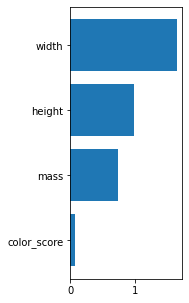

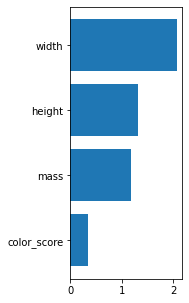

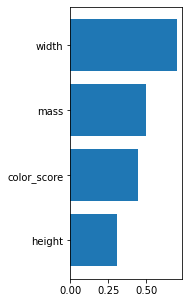

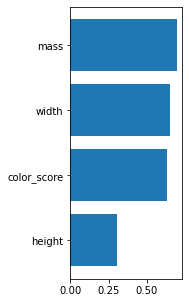

In [20]:
from sklearn.preprocessing import MinMaxScaler
sscaler = MinMaxScaler()
df_fruits_ext = df_fruits.copy()
#df_fruits_ext['mwh'] = df_fruits.width * df_fruits.height * (df_fruits.mass**2) * df_fruits.color_score
df_fruits_ext['mwh'] = df_fruits.width * df_fruits.height * (df_fruits.color_score**2) * df_fruits.mass
X = df_fruits_ext[['mass', 'width', 'height', 'color_score', 'mwh']]
XX = sscaler.fit_transform(X.astype(float))
X = pd.DataFrame(data = XX,columns = ['mass', 'width', 'height', 'color_score', 'mwh'])
y = df_fruits['fruit_label']

df = print_output(X, y)

In [21]:
display(df)

,Machine Learning Method,Test Accuracy,Best Parameter,Top Mean Predictor Variable,Mean Predictor Per Class,Run Time
0,kNN,0.957778,N_Neighbor = 4,NA,NA,3.577950
1,Logistic (l2),0.806667,C = 300,width,"[1: width, 2: height, 3: mwh, 4: height]",2.823634
2,Logistic (l1),0.806667,C = 100,width,"[1: width, 2: height, 3: mwh, 4: height]",6.425447
3,Linear SVM (l2),0.728889,C = 300,width,"[1: mwh, 2: height, 3: mass, 4: height]",23.462282
4,Linear SVM (l1),0.717778,C = 20,mass,"[1: mwh, 2: height, 3: mass, 4: width]",2.233504


### Doubling the color_score value

Doubling the color_score value did not help due to the fact that it will jsut be scaled down but we wanted to test if there would be any further difference.

KNN Start: 2022-11-02 22:27:51.616237
['kNN', 0.9555555555555557, 'N_Neighbor = 4', 'NA', 'NA', 3.5507991313934326]
NA seconds
Logistics l2 Start: 2022-11-02 22:27:55.167036
['Logistic (l2)', 0.8133333333333338, 'C = 5000', 'width', ['1: width', '2: height', '3: mass', '4: height'], 2.9986753463745117]
['1: width', '2: height', '3: mass', '4: height'] seconds
Logistics l1 Start: 2022-11-02 22:27:58.165712
['Logistic (l1)', 0.8133333333333338, 'C = 100', 'width', ['1: width', '2: height', '3: mwh', '4: height'], 7.784752607345581]
['1: width', '2: height', '3: mwh', '4: height'] seconds
SVCM l2 Start: 2022-11-02 22:28:05.951465
['Linear SVM (l2)', 0.7466666666666668, 'C = 5000', 'mass', ['1: mwh', '2: height', '3: mwh', '4: height'], 21.58487868309021]
['1: mwh', '2: height', '3: mwh', '4: height'] seconds
SVCM l1 Start: 2022-11-02 22:28:27.536343
['Linear SVM (l1)', 0.7533333333333335, 'C = 100', 'mass', ['1: mwh', '2: height', '3: mwh', '4: width'], 8.701960563659668]
['1: mwh', '2: h

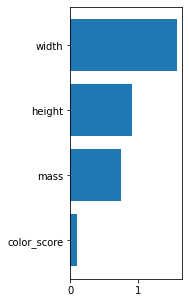

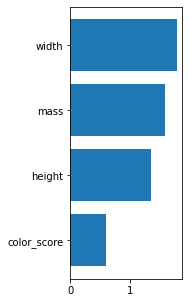

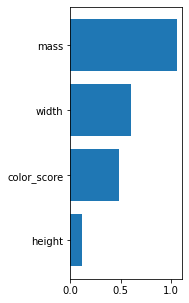

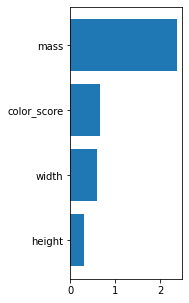

In [28]:
from sklearn.preprocessing import MinMaxScaler
sscaler = MinMaxScaler()
df_fruits_ext = df_fruits.copy()
#df_fruits_ext['mwh'] = df_fruits.width * df_fruits.height * (df_fruits.mass*2)
df_fruits_ext['mwh'] = df_fruits.width * df_fruits.height * (df_fruits.color_score*2)
X = df_fruits_ext[['mass', 'width', 'height', 'color_score', 'mwh']]
XX = sscaler.fit_transform(X.astype(float))
X = pd.DataFrame(data = XX,columns = ['mass', 'width', 'height', 'color_score', 'mwh'])
y = df_fruits['fruit_label']

df = print_output(X, y)

In [27]:
display(df)

,Machine Learning Method,Test Accuracy,Best Parameter,Top Mean Predictor Variable,Mean Predictor Per Class,Run Time
0,kNN,0.955556,N_Neighbor = 4,NA,NA,3.511790
1,Logistic (l2),0.813333,C = 5000,width,"[1: width, 2: height, 3: mass, 4: height]",2.988673
2,Logistic (l1),0.813333,C = 100,width,"[1: width, 2: height, 3: mwh, 4: height]",7.850211
3,Linear SVM (l2),0.746667,C = 5000,mass,"[1: mwh, 2: height, 3: mwh, 4: height]",21.111755
4,Linear SVM (l1),0.753333,C = 100,mass,"[1: mwh, 2: height, 3: mwh, 4: width]",8.737967


### Using mass and squaring it

We just wanted to show if we used mass instead of color_score it still increases it across the models however it does not push KNN to 96.88% with K=1 here we are at 96% with K=4

KNN Start: 2022-11-02 22:32:17.496556
['kNN', 0.9600000000000002, 'N_Neighbor = 4', 'NA', 'NA', 3.5267975330352783]
NA seconds
Logistics l2 Start: 2022-11-02 22:32:21.023354
['Logistic (l2)', 0.8244444444444449, 'C = 5000', 'width', ['1: width', '2: height', '3: mwh', '4: height'], 3.215723991394043]
['1: width', '2: height', '3: mwh', '4: height'] seconds
Logistics l1 Start: 2022-11-02 22:32:24.239078
['Logistic (l1)', 0.8244444444444449, 'C = 300', 'width', ['1: width', '2: height', '3: mwh', '4: height'], 8.564928770065308]
['1: width', '2: height', '3: mwh', '4: height'] seconds
SVCM l2 Start: 2022-11-02 22:32:32.805007
['Linear SVM (l2)', 0.7688888888888893, 'C = 5000', 'width', ['1: mwh', '2: height', '3: mass', '4: height'], 21.54485034942627]
['1: mwh', '2: height', '3: mass', '4: height'] seconds
SVCM l1 Start: 2022-11-02 22:32:54.350857
['Linear SVM (l1)', 0.8044444444444446, 'C = 5000', 'mass', ['1: mwh', '2: height', '3: mass', '4: width'], 5.2124786376953125]
['1: mwh', '2

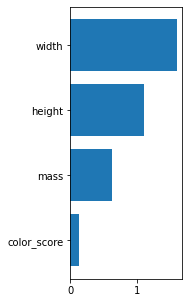

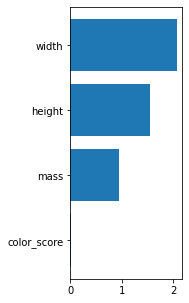

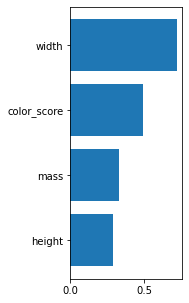

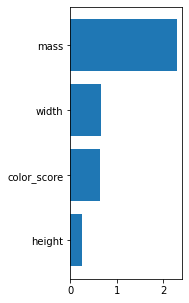

In [31]:
from sklearn.preprocessing import MinMaxScaler
sscaler = MinMaxScaler()
df_fruits_ext = df_fruits.copy()
df_fruits_ext['mwh'] = df_fruits.width * df_fruits.height * (df_fruits.mass**2)
#df_fruits_ext['mwh'] = df_fruits.width * df_fruits.height * (df_fruits.color_score**2)
X = df_fruits_ext[['mass', 'width', 'height', 'color_score', 'mwh']]
XX = sscaler.fit_transform(X.astype(float))
X = pd.DataFrame(data = XX,columns = ['mass', 'width', 'height', 'color_score', 'mwh'])
y = df_fruits['fruit_label']

df = print_output(X, y)

In [ ]:
display(df)

### Conclusion

We conclude that after these iterations of test we wanted to use KNN with K = 1 and utilizing the derived feature of width*height*(color_score**2) with the width being the top predictor in almost all models except SVM L1 having mass as its top predictor. Based also on resaerch for multi class classification its best to use KNN or Random Forest vs Linear models.